In [4]:
# Import Modules Needed

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import erfc
from PIL import Image as im 
from matplotlib import animation, rc
plt.rc('animation', html='jshtml')
from IPython.display import HTML
import subprocess as sp
import sys,math
import sympy as sym
import matplotlib.font_manager
from IPython.core.display import HTML
def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)
code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])
# HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [10]:
# Little function to tell you how long the for loop is running, courtesy of Kirk Long

def trackPercent(place,totalLength,strLen): #percent output tracker
    percent = place/totalLength*10
    if math.floor(percent)==69:
        string="{:.2f} % complete -- nice".format(percent)
    else:
        string="{:.2f} % complete".format(percent)
    sys.stdout.write("\r") #this "moves the cursor" to the beginning of the I0 line
    sys.stdout.write(" "*strLen) #this "clears" whatever was on the line last time by writing whitespace
    sys.stdout.write("\r") #move the cursor back to the start again
    sys.stdout.write(string) #display the current percent we are at
    sys.stdout.flush() #flush finishes call to print() (this is like what's under the hood of print function)
    strLen=len(string) #return the new string length for next function call
    return strLen
#--NotebookApp.iopub_data_rate_limit=1.0e10

In [6]:
# Class function containing various algorithms to solve the diffusion of heat through an asteroid

class pde_solver():
    def __init__(self,zp,dzp,tp,kappa,uc,omegap, T0,mu,kk):
    
    #'''
    # Solve the 1d diffusion equation using finite differences method, with inputs for the 
    # spatial range (L), total time (t), initial condition (T0), diffusion coeffecient 
    # (kappa), number of timesteps (Nt), number of spatial nodes (Nz), frequency (omega), physical characteristics
    # constant (mu), and thermal conductivity (kk)
    #'''
        self.kappa=kappa
        self.Uc=uc
        
        
        self.zc=self.kappa/self.Uc        
        self.dzp=dzp
        self.zp=np.arange(0,zp,self.dzp)
        self.dz=self.dzp*self.zc
        self.z=np.arange(0,zp*self.zc,self.dz)
    
        self.tc=self.zc**2/self.kappa
        self.dt=0.9*self.dz**2/(2*self.kappa)
        self.dtp=self.dt/self.tc
        self.tp=np.arange(0,tp,self.dtp) 
        self.t=np.arange(0,tp*self.tc,self.dt)
        
        self.wp=omegap
        self.wc=1/self.tc
        self.w=self.wp*self.wc
        print('Wc = {:.2e}, and W = {:.2e}'.format(self.wc,self.w))
        self.T0=T0
        self.mu=mu
        self.kk=kk
        # Define timestep to satisfy stability req't
        self.r = self.kappa*self.dt/(self.dz**2) # Diffusion condition
        self.d=self.mu*self.kappa/self.kk # radiative loss term
        print("Step size: dt = {:.2e}".format(self.dt))
        self.Nz = len(self.z)
        self.Nt = len(self.t)
        self.T_sol=None
        self.T=None
        self.TR=None
    def numerical(self,double=True):
        '''Function to compute, with centered finite differences, the temperature evolution in an asteroid
        rotating in space'''
        
        self.Tr=np.zeros((self.Nt, self.Nz+2))
        print (np.shape(self.Tr))
        # Insert boundary conditions
        self.Tr[:,0] =self.T0-self.T0*np.cos(self.w*self.t)#+ self.T0*(np.sin(self.omega*self.t -np.pi/2))#self.T0+
        if double:
            self.Tr[:,-1] = self.T0+self.T0*np.cos(self.w*self.t)#+self.T0*(-np.sin(self.omega*self.t -np.pi/2))
        for i in range(1, self.Nt):
            # Compute u at inner mesh points for i in range(1, Nz):
            self.Tr[i,1:-1] =  self.Tr[i-1,1:-1] + self.r * (self.Tr[i-1,2:] - 2*self.Tr[i-1,1:-1] + self.Tr[i-1,:-2]) 

        self.T =self.Tr[:,1:-1]

    def numerical_const(self):
        self.Tc=np.zeros((self.Nt, self.Nz+2))
        self.Tc[:,0] = 1
        for i in range(1, self.Nt):
            # Compute u at inner mesh points for i in range(1, Nz):
            self.Tc[i,1:-1] =  self.Tc[i-1,1:-1] + self.r * (self.Tc[i-1,2:] - 2*self.Tc[i-1,1:-1] + self.Tc[i-1,:-2]) 
        self.Tc=self.Tc[:,1:-1] 
        
        
    def numerical_plus_radiative(self, double=True):
        '''Function to compute the modified diffusion equation, that with a radiative loss term, describing an
        asteroid which loses heat to its surroundings'''
        self.TR=np.zeros((self.Nt, self.Nz+2))
        str_len = 0
        # Insert boundary conditions
        self.TR[:,0] =self.T0- self.T0*np.cos(self.w*self.t)#self.T0*(np.sin(self.omega*self.t -np.pi/2))#self.T0+
        if double:
            self.TR[:,-1] = self.T0+self.T0*np.cos(self.w*self.t)#+self.T0*(-np.sin(self.omega*self.t -np.pi/2))
            for i in range(1, self.Nt):
                # Compute u at inner mesh points for i in range(1, Nz):
                self.TR[i,1:-1] =  self.TR[i-1,1:-1] + self.r * (self.TR[i-1,2:] - 2*self.TR[i-1,1:-1] + self.TR[i-1,:-2]) 
                if self.TR[i,-1]<self.TR[i,-2]:
                    self.TR[i,-1]=self.TR[i,-2]-self.d*(self.TR[i,-2]**4-self.TR[i,-1]**4) 
                if self.TR[i,0]<self.TR[i,1]:
                    self.TR[i,0]=self.TR[i,1]-self.d*(self.TR[i,1]**4-self.TR[i,0]**4)
        else:
            for i in range(1, self.Nt):
                # Compute u at inner mesh points for i in range(1, Nz):
                self.TR[i,1:-1] =  self.TR[i-1,1:-1] + self.r * (self.TR[i-1,2:] - 2*self.TR[i-1,1:-1] + self.TR[i-1,:-2]) 
                self.TR[i,-1]=self.TR[i,-2]-self.d*(self.TR[i,-2]**4)
        self.TR=self.TR[:,1:-1] 
       
#     def analytic(self):
#         t_a=self.t.reshape(self.Nt,1)
#         z_a=self.z.reshape(1,self.Nz)
#         self.k =np.sqrt(self.w/(2*self.kappa))#*(self.dz**2/self.L**2)))
#         #self.a=self.k*z_a - self.omega*t_a
#         self.T_sol=np.zeros((self.Nt, self.Nz))
#         for i in range(self.Nt):#np.cos(self.k*self.z) -
#             for j in range(self.Nz):
#                 self.T_sol[i,j]=self.T0*np.exp(-self.k*self.z[j])*np.cos( self.k*self.z[j] - self.w*self.t[i])#(np.cos(self.k*self.z) -

        
    def analytic_const(self):
        from scipy import special
        self.Tc_sol=np.zeros((self.Nt, self.Nz))
        for i in range(1, self.Nt):#np.exp(self.k*self.z)
            self.Tc_sol[i]=special.erfc(self.z/(2*np.sqrt(self.kappa*self.t[i])))#(np.cos(self.k*self.z) -
                

In [7]:
l,w,nu=sym.symbols('lambda omega nu')
sym.solve(l**2+sym.I*w/nu, l)

[-sqrt(-I*omega/nu), sqrt(-I*omega/nu)]

In [8]:
# Let's solve!
#solve = pde_solver(zp=1,dzp=0.01,tp=1,kappa=3,uc=1,omegap=15, T0=2,mu=5,kk=7)
#dzp,kappa,uc,omegap, T0,mu,kk
#solve.numerical(double=True)
#solve.numerical_plus_radiative(double=True)
#solve.numerical_const()
#solve.numerical_const()

#solve.analytic_const()
solve2 = pde_solver(zp=10,dzp=0.01,tp=1,kappa=3,uc=1,omegap=15, T0=2,mu=5,kk=7)
solve2.numerical_const()
#solve2=pde_solver(L=500, t_tot=50000, T0=1, kappa=1.5, dz=1, omega=0.5e-3,mu=1,kk=5)
solve2.analytic_const()
#solve2 = pde_solver(L=100, t_tot=100000, T0=3, kappa=0.5, dz=1, omega=1e-2,mu=1e-2,kk=3)
#solve2.numerical(double=False)

Wc = 3.33e-01, and W = 5.00e+00
Step size: dt = 1.35e-04


In [96]:
np.testing.assert_allclose(solve2.Tc[:,300], solve2.Tc_sol[:,300], atol=1e-3)


Radiative loss: 2.142857142857143
diffusion term 0.25


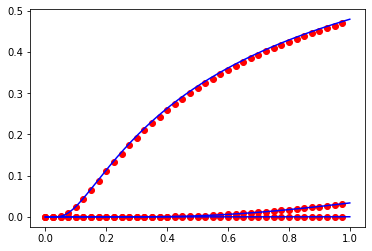

In [89]:
# Plotting

ratio=1#0.01*solve.Nt/solve.Nz

print ('Radiative loss:',solve.d)
print("diffusion term",solve.r)
#plt.figure(figsize=(8,8))
#plt.pcolormesh(solve2.T.T,vmin=0,vmax=6,aspect=ratio,origin='lower',extent=(0,solve.t_tot,0,solve.L))
#plt.ylabel('Length'); plt.xlabel('Time')
#plt.title('Numerical Solution, kappa = {} '.format(solve2.kappa),size=12)
#plt.colorbar()
#plt.show()
# plt.figure(figsize=(8,8))
# plt.pcolormesh(solve.tp,solve.zp,solve.T.T,vmin=0,vmax=4,  cmap='rainbow',shading='auto')
# plt.ylabel('Length'); plt.xlabel('Time')
# plt.colorbar()
# plt.title('Numerical Solution, kappa = {} '.format(solve.kappa),size=12)
# plt.show()
# plt.close()

# plt.figure(figsize=(8,8))
# plt.pcolormesh(solve.tp,solve.zp,solve.TR.T,vmin=0,vmax=4,  cmap='rainbow', shading='auto')#aspect=ratio,origin='lower',extent=(0,1,0,1))
# plt.ylabel('Length'); plt.xlabel('Time')
# plt.colorbar()
# plt.title('Numerical Radiative Solution, kappa = {} '.format(solve.kappa),size=12)
# plt.show()
# plt.close()

# plt.figure(figsize=(8,8))
# plt.pcolormesh(solve.tp,solve.zp,solve.T_sol.T,vmin=0,vmax=4,  cmap='rainbow',shading='auto')# aspect=ratio,origin='lower',extent=(0,1,0,1))
# plt.ylabel('Length'); plt.xlabel('Time')
# plt.colorbar()
# plt.title('Analytic Solution, kappa = {} '.format(solve.kappa),size=12)
# plt.show()
# plt.close()

# plt.figure(figsize=(8,8))
# plt.pcolormesh(solve.tp,solve.zp,solve.Tc.T,vmin=0,vmax=1, cmap='rainbow', shading='auto')# aspect=ratio,origin='lower',extent=(0,1,0,1))
# plt.ylabel('Length'); plt.xlabel('Time')
# plt.colorbar()
# plt.title('Const Numerical Solution, kappa = {} '.format(solve.kappa),size=12)
# plt.show()
# plt.close()

# plt.figure(figsize=(8,8))
# plt.pcolormesh(solve2.tp,solve2.zp,solve2.Tc.T,vmin=0,vmax=1, cmap='rainbow',shading='auto')
# plt.ylim(0,1)
# plt.ylabel('Length'); plt.xlabel('Time')
# plt.colorbar()
# plt.title('Const Numerical Solution,zp = 100, kappa = {} '.format(solve2.kappa),size=12)
# plt.show()
# plt.close()

# plt.figure(figsize=(8,8))
# plt.pcolormesh(solve2.tp,solve2.zp,solve2.Tc_sol.T,vmin=0,vmax=1, cmap='rainbow',shading='auto')
# plt.ylim(0,1)
# plt.ylabel('Length'); plt.xlabel('Time')
# plt.colorbar()
# plt.title('Const AnalyticSolution,zp = 100, kappa = {} '.format(solve2.kappa),size=12)
# plt.show()
# plt.close()

#plt.figure(figsize=(8,8))
#plt.pcolormesh(solve.TR.T,vmin=0,vmax=2,  aspect=ratio,origin='lower',extent=(0,solve.t_tot,0,solve.L))
#plt.ylabel('Length'); plt.xlabel('Time')
#plt.colorbar()

#plt.title('Radiative Numerical Solution, kappa = {} '.format(solve.kappa),size=12)
#plt.show()
plt.plot(solve2.tp,solve2.Tc_sol[:,100],c='blue')
plt.scatter(solve2.tp[0::1000],solve2.Tc[0::1000,100],color='red')

plt.plot(solve2.tp,solve2.Tc_sol[:,300],c='blue')
plt.scatter(solve2.tp[0::1000],solve2.Tc[0::1000,300],color='red')

plt.plot(solve2.tp,solve2.Tc_sol[:,500],c='blue')
plt.scatter(solve2.tp[0::1000],solve2.Tc[0::1000,500],color='red')
# plt.figure(figsize=(8,8))
# plt.pcolormesh(solve.tp,solve.zp,solve.Tc_sol.T,vmin=0,vmax=1,   cmap='rainbow',shading='auto')#aspect=ratio,origin='lower',extent=(0,1,0,1))
# plt.ylabel('Length'); plt.xlabel('Time')
# plt.colorbar()
# plt.title('Const Analytic Solution, kappa = {} '.format(solve.kappa),size=12)
# plt.show()
# plt.close()
#plt.plot(solve.T[:,-1],color='k')
#plt.plot(solve.T[:,-2],color='red')
#plt.plot(solve.T[:,-3],color='blue')
#plt.ylim(0.6,1)
#plt.grid()

In [ ]:
z0=0#int(len(solve.z)/5)
#plt.plot(solve.t,solve.T_R[:,z0],label='Analytic Solution R')#marker='o',size=20
#plt.plot(solve.t,solve.T_L[:,z0],label='Analytic Solution L')#marker='o',size=20
plt.plot(solve.t,solve.T[:,z0],label='Numerical Solution')
plt.plot(solve.t,solve.T_sol[:,z0],label='Analytic Solution')#marker='o',size=20
plt.legend(loc=0,ncol=1,prop={'size':12},frameon=False)
plt.grid()
plt.show()

## Exploring Parameter Space